# English Premier League (EPL) Match Outcome Prediction

### Introduction:

This project aims to predict the results of English Premier League (EPL) matches using machine learning. I am using 3 models, namely - Logistic Regression, Random Forest Classifier and XGBoost Classifier.

This dataset comes from the **Kaggle English Premier League dataset** and has data about match results, team stats and past performance data.

### Dataset Columns:

- **Date** - Date of the match
- **HomeTeam** - Name of the home team
- **AwayTeam** - Name of the away team
- **FTHG, FTAG** - Full-time Home / Away  team goals
- **FTR** - Full-time result (H: Home win, A: Away win, D: Draw)
- **HTGS, ATGS** - Home / Away  team total goals scored before the match
- **HTGC, ATGC** - Home / Away team total goals conceded before the match
- **HTP, ATP** - Home / Away team total points before the match
- **HMx, AMx** - Home team result in match 'x' (W, D, L)
- **MW** - Match week number
- **HTFormPtsStr, ATFormPtsStr** - Home / Away  team's recent form as a string (WWDDL)
- **HTFormPts, ATFormPts** - Home / Away  team's recent form points
- **HTWinStreak3, ATWinStreak3** - Home / Away  team 3-match winning streak (1 = Yes, 0 = No)
- **HTWinStreak5, ATWinStreak5** - Home / Away  team 5-match winning streak
- **HTLossStreak3, ATLossStreak3** - Home / Away  team 3-match losing streak
- **HTLossStreak5, ATLossStreak5** - Home / Away  team 5-match losing streak
- **HTGD, ATGD** - Home / Away  team goal difference (scored - conceded)
- **DiffPts** - Difference in total points between home and away teams
- **DiffFormPts** - Difference in form points between home and away teams

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import os
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
file = os.path.join('archive','final_dataset.csv')
ds = pd.read_csv(file)
print(ds.info())

# Encoding FTR to numeric
ds['FTR_encoded'] = ds['FTR'].map({'NH': 1, 'H': 0})

print('\n\n')
print(ds.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6840 entries, 0 to 6839
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     6840 non-null   int64  
 1   Date           6840 non-null   object 
 2   HomeTeam       6840 non-null   object 
 3   AwayTeam       6840 non-null   object 
 4   FTHG           6840 non-null   int64  
 5   FTAG           6840 non-null   int64  
 6   FTR            6840 non-null   object 
 7   HTGS           6840 non-null   int64  
 8   ATGS           6840 non-null   int64  
 9   HTGC           6840 non-null   int64  
 10  ATGC           6840 non-null   int64  
 11  HTP            6840 non-null   float64
 12  ATP            6840 non-null   float64
 13  HM1            6840 non-null   object 
 14  HM2            6840 non-null   object 
 15  HM3            6840 non-null   object 
 16  HM4            6840 non-null   object 
 17  HM5            6840 non-null   object 
 18  AM1     

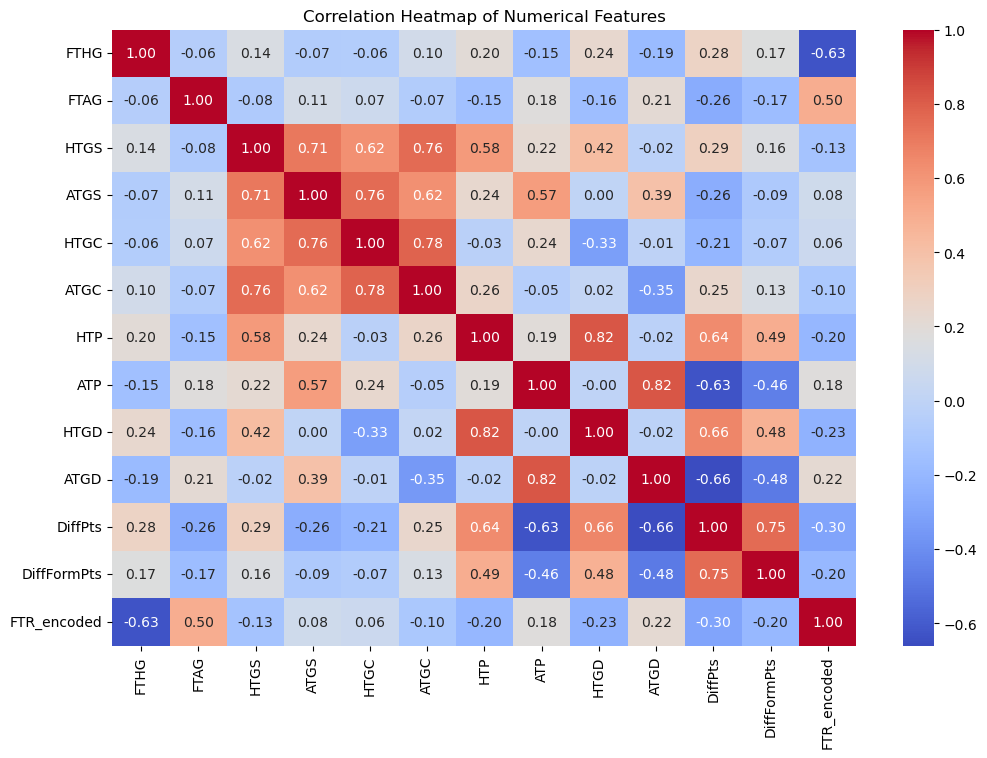

In [3]:
# Select numerical columns for correlation analysis
numerical_columns = ['FTHG', 'FTAG', 'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HTP', 'ATP', 'HTGD', 'ATGD', 'DiffPts', 'DiffFormPts','FTR_encoded']
corr_matrix = ds[numerical_columns].corr()
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

### Redundant Columns
- FTHG and FTAG are highly correlated with FTR_encoded but are redundant because they are directly derived from the match outcome. I am predicting the outcome (FTR), so including these would lead to data leakage.

   
    
- HTGS, ATGS, HTGC, ATGC are highly correlated with each other and with HTGD and ATGD. I am dropping these columns and keep HTGD and ATGD.
    
   

### Irrelevant Columns
- Date, HomeTeam, AwayTeam are not directly relevant to the prediction task. Team names are categorical and would require encoding, but we already have numerical features like HTP and ATP to represent team strength.
      
- HM4, HM5, AM4, AM5 represent older match results (4th and 5th last matches). I am removing them to make it less complicated.
     
- MW (Match Week) is not directly relevant to the prediction task.
    
### Low Correlation with Target

- DiffPts (Difference in Points) has a weak correlation with FTR_encoded (-0.30), which shows that it may not be very useful for prediction.
    
- DiffFormPts (Difference in Form Points) also has weak correlation with FTR_encoded (-0.20), making it less important.

### Categorical Columns
- HTFormPtsStr, ATFormPtsStr represent form as a string. We already have numerical form points (HTFormPts and ATFormPts), so these are redundant.

### Streak Columns
- HTWinStreak3, HTWinStreak5, HTLossStreak3, HTLossStreak5, ATWinStreak3, ATWinStreak5, ATLossStreak3, ATLossStreak5 - These columns represent streaks, which may not add significant value compared to other features.
    

In [4]:
# Dropping unnecessary columns
df = ds.drop(['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG',
       'HTGS', 'ATGS', 'HTGC', 'ATGC', 'HM4', 'HM5', 'AM4', 'AM5', 'MW', 'HTFormPtsStr',
       'ATFormPtsStr', 'HTFormPts', 'ATFormPts', 'HTWinStreak3',
       'HTWinStreak5', 'HTLossStreak3', 'HTLossStreak5', 'ATWinStreak3',
       'ATWinStreak5', 'ATLossStreak3', 'ATLossStreak5', 'DiffPts'], axis = 1)

print(df.columns)
print('\n\n')
print(df.head(10))

Index(['Unnamed: 0', 'FTR', 'HTP', 'ATP', 'HM1', 'HM2', 'HM3', 'AM1', 'AM2',
       'AM3', 'HTGD', 'ATGD', 'DiffFormPts', 'FTR_encoded'],
      dtype='object')



   Unnamed: 0 FTR  HTP  ATP HM1 HM2 HM3 AM1 AM2 AM3  HTGD  ATGD  DiffFormPts  \
0           0   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
1           1   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
2           2  NH  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
3           3  NH  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
4           4   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
5           5  NH  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
6           6   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
7           7   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
8           8   H  0.0  0.0   M   M   M   M   M   M   0.0   0.0          0.0   
9           9   H  0.0  0.0   M   M  

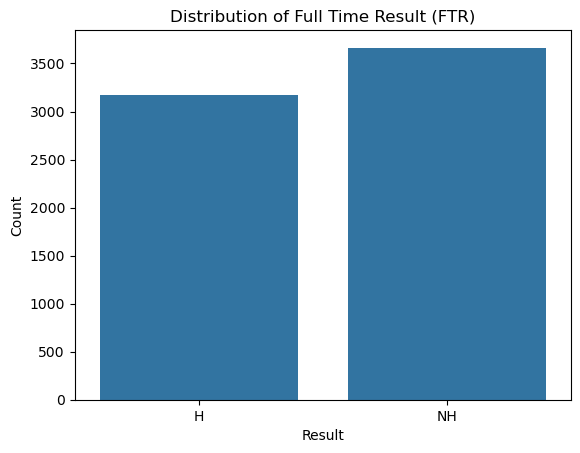

In [5]:
sns.countplot(x='FTR', data=ds)
plt.title('Distribution of Full Time Result (FTR)')
plt.xlabel('Result')
plt.ylabel('Count')
plt.show()

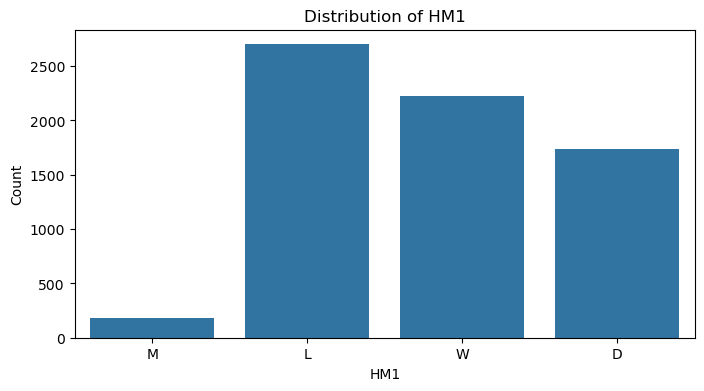

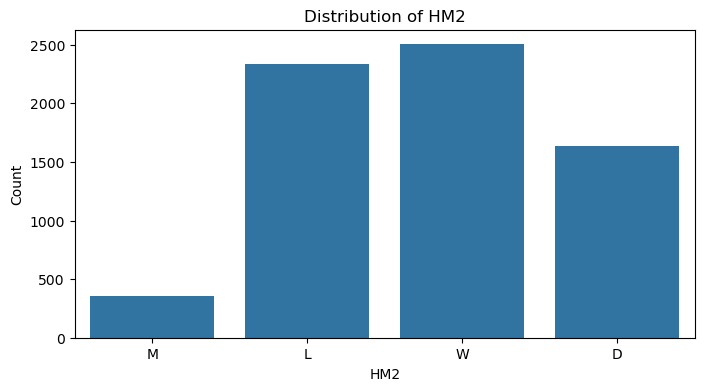

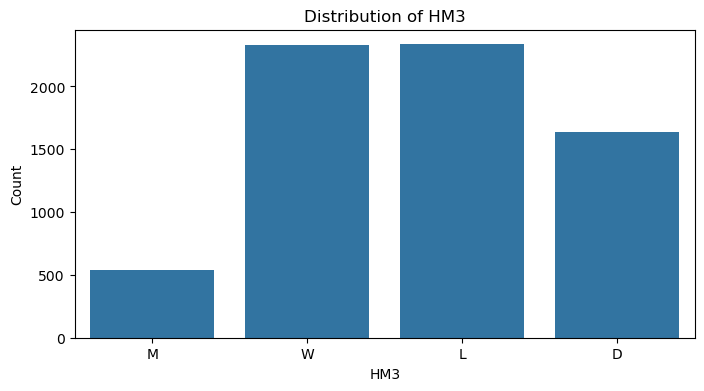

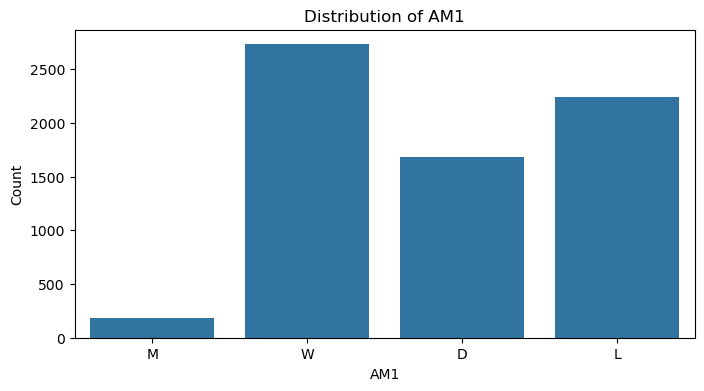

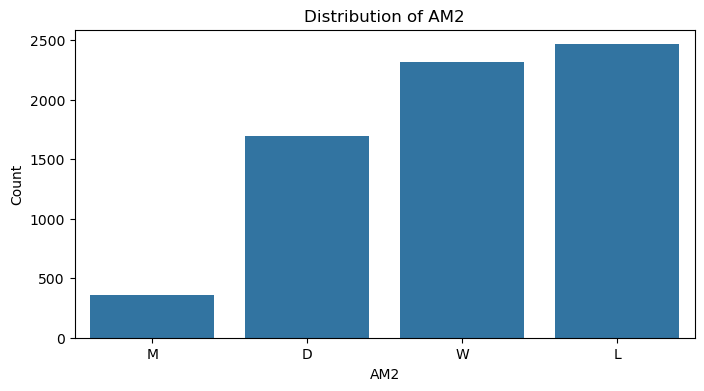

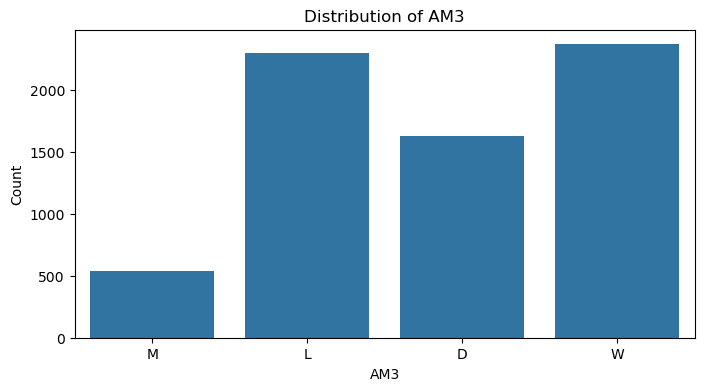

In [6]:
categorical_columns = ['HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3']
for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=ds)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [7]:
X = df.drop(['FTR','FTR_encoded'], axis=1)
y = df['FTR_encoded']

# Scaling the numerical features
numerical_columns = ['HTGD', 'ATGD', 'HTP', 'ATP']

categorical_columns = ['HM1', 'HM2', 'HM3', 'AM1', 'AM2', 'AM3']
X = pd.get_dummies(X, columns=categorical_columns)

print(X.head)

<bound method NDFrame.head of       Unnamed: 0       HTP       ATP      HTGD      ATGD  DiffFormPts  HM1_D  \
0              0  0.000000  0.000000  0.000000  0.000000     0.000000  False   
1              1  0.000000  0.000000  0.000000  0.000000     0.000000  False   
2              2  0.000000  0.000000  0.000000  0.000000     0.000000  False   
3              3  0.000000  0.000000  0.000000  0.000000     0.000000  False   
4              4  0.000000  0.000000  0.000000  0.000000     0.000000  False   
...          ...       ...       ...       ...       ...          ...    ...   
6835        6835  1.078947  1.842105 -0.289474  0.710526    -0.263158  False   
6836        6836  0.947368  2.552632 -0.473684  2.052632    -0.131579  False   
6837        6837  0.868421  0.789474 -0.710526 -0.894737    -0.052632  False   
6838        6838  1.947368  1.236842  0.973684 -0.078947     0.078947  False   
6839        6839  1.026316  1.289474 -0.578947 -0.315789    -0.105263   True   

      HM1

In [8]:
# Splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

Logistic Regression Accuracy: 0.6491228070175439
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       634
           1       0.65      0.73      0.69       734

    accuracy                           0.65      1368
   macro avg       0.65      0.64      0.64      1368
weighted avg       0.65      0.65      0.65      1368



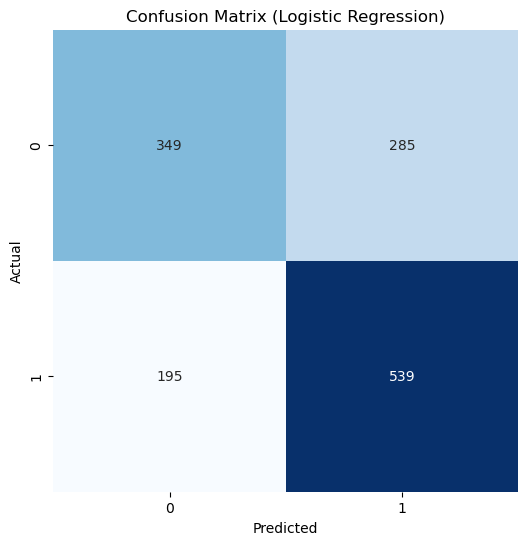

In [9]:
logistic_model = LogisticRegression(random_state=0, max_iter=1000)
logistic_model.fit(X_train, y_train)
logistic_predictions = logistic_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, logistic_predictions))
print(classification_report(y_test, logistic_predictions))

cm = confusion_matrix(y_test, logistic_predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Random Forest Model

In [10]:
random_forest_model = RandomForestClassifier(n_estimators=700, min_samples_split=10, random_state=1, n_jobs=-1)
random_forest_model.fit(X_train, y_train)
random_forest_predictions = random_forest_model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, random_forest_predictions))
print(classification_report(y_test, random_forest_predictions))


Random Forest Accuracy: 0.6403508771929824
              precision    recall  f1-score   support

           0       0.63      0.55      0.58       634
           1       0.65      0.72      0.68       734

    accuracy                           0.64      1368
   macro avg       0.64      0.63      0.63      1368
weighted avg       0.64      0.64      0.64      1368



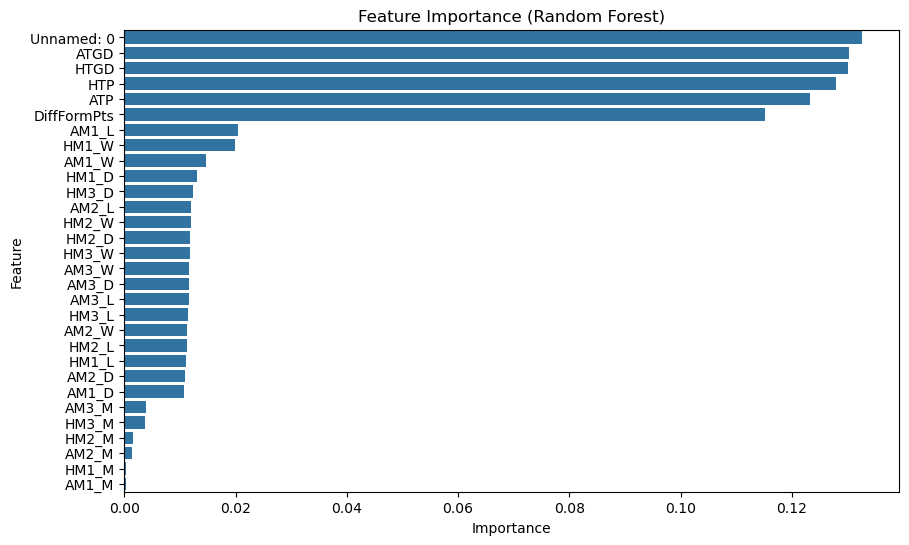

In [11]:
importances = random_forest_model.feature_importances_
feature_names = X.columns
# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### XGBoost Model

In [12]:
xgboost_model = XGBClassifier(seed=82)
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgboost_predictions))
print(classification_report(y_test, xgboost_predictions))

XGBoost Accuracy: 0.6030701754385965
              precision    recall  f1-score   support

           0       0.58      0.53      0.55       634
           1       0.62      0.66      0.64       734

    accuracy                           0.60      1368
   macro avg       0.60      0.60      0.60      1368
weighted avg       0.60      0.60      0.60      1368



### **Model Comparison and Selection**

After evaluating three models (Logistic Regression, Random Forest, and XGBoost), **Logistic Regression** emerged as the best model based on the following metrics:

- **Accuracy**: 64.91% (highest among the three models).
- **F1-Score**: 
  - Class 0: 0.59
  - Class 1: 0.69
- **Balanced Performance**: Logistic Regression performs well across both classes.

#### **Why Logistic Regression?**
- It is simple, interpretable, and performs well on binary classification tasks.
- It achieved the highest accuracy and F1-score compared to Random Forest and XGBoost.